In [1]:
import numpy as np
import tensorflow as tf
import os
import pickle 
import matplotlib.pyplot as plt

2025-02-19 10:30:24.442234: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = '/standard/sds_baek_energetic/data/physics/Shahab_Latent_PARC'
module_dir = os.path.join( base_dir, 'Multiscale-Latent-Dynamics/Multiscale-Latent-Dynamics' ) 
data_dir = os.path.join( base_dir, 'Processed_data/single_void_state' ) 

In [3]:
# local modules
import sys
sys.path.append(module_dir)
from models.micro_dynamics_coupled import MicroDynamicsCoupled
from models.micro_dynamics_coupled_efficient import MicroDynamicsCoupledEfficient
from utils.train_utils import in_out_latent_dataset, in_out_dataset, CheckPoint
from utils.dir_hyper import dyn_dir, mkdir_ifnot
from utils.visualization import plot_pred_field

### Load data

In [4]:
state_traj = np.load(os.path.join(data_dir, 'augment_state_160_256_20ts.npy'))
state_traj.shape

(238, 160, 256, 3, 20)

In [5]:
latent_mean_traj = np.load( os.path.join( data_dir, "encoded_latent_mean_fields_traj_20_32.npy" ) )
latent_var_traj = np.load( os.path.join( data_dir, "encoded_latent_var_fields_traj_20_32.npy" ) )
print((latent_mean_traj.shape, latent_var_traj.shape))

((238, 20, 32, 12, 20), (238, 20, 32, 12, 20))


### MicroDynamicsCoupled prediction

In [6]:
ts_idx = 7
n_epochs = 40
fields = ['temperature', 'pressure', 'microstructure']
dynamics_model = 'unet'
dir = f"{dyn_dir(dynamics_model)['micro_dyn']['coupled']}"
weight_dir = os.path.join(dir, f'weights_{ts_idx+1}_ts_train_238')


micro_dynamics_coupled = MicroDynamicsCoupled(ts = ts_idx + 1, 
                                            fields = fields, 
                                            output_fields = list(enumerate(fields)), 
                                            input_shape = (160, 256, 3), 
                                            loss_weights = [0., 0., 1., 1., 1.],
                                            dynamics_model=dynamics_model)

# Call LatentPARC_Coupled on a sample to create the model's variables before being able to load the weights
init_x_gt = state_traj[0:1, ..., 0:1]
output_fields = list(enumerate(fields))
input = [init_x_gt, 1, output_fields]
micro_dynamics_coupled.call(input)
##
# load pretrain weights of the decoupled evolutions
micro_dynamics_coupled.load_micro_decoupled_evol(pretrain_ts=[0, 0, 0], n_epochs=[0, 0, 0])
###
micro_dynamics_coupled.load_weight(ts=ts_idx+1, n_epochs=n_epochs, weight_dir=weight_dir)
micro_dynamics_coupled.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.99))

2025-02-19 10:30:56.016814: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1275 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-02-19 10:31:00.114276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-02-19 10:31:00.671432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [7]:
sample = 232 # use samples 50 and 112
init_step = 0
evol_step = 19
init_x_gt = state_traj[sample:sample+1, :,:,:, init_step:init_step+1]
output_fields = list(enumerate(fields)) # output_fields is of the form [(field_idx, field_name)]
input = [init_x_gt, evol_step, output_fields]
x_evol_traj, z_mean_traj, z_var_traj = micro_dynamics_coupled.call(input)
x_evol_traj, z_mean_traj, z_var_traj = x_evol_traj.numpy(), z_mean_traj.numpy(), z_var_traj.numpy()
print((x_evol_traj.shape, z_mean_traj.shape)) 

((1, 160, 256, 3, 20), (1, 20, 32, 12, 20))


In [8]:
field_idx = 0
field_gt = state_traj[sample:sample+1,:,:, field_idx:field_idx+1, init_step:init_step+evol_step+1]
c0, c1 = (field_idx * micro_dynamics_coupled.latent_shape[2]), (( field_idx + 1) * micro_dynamics_coupled.latent_shape[2]) 
x = np.moveaxis(np.concatenate([field_gt, x_evol_traj[..., field_idx:field_idx+1, :]], axis=0), (0,1,2,3,4), (0,2,3,4,1))
z = np.moveaxis(np.concatenate([z_mean_traj[..., c0:c1, :], z_var_traj[..., c0:c1, :]], axis=0), (0,1,2,3,4), (0,2,3,4,1))

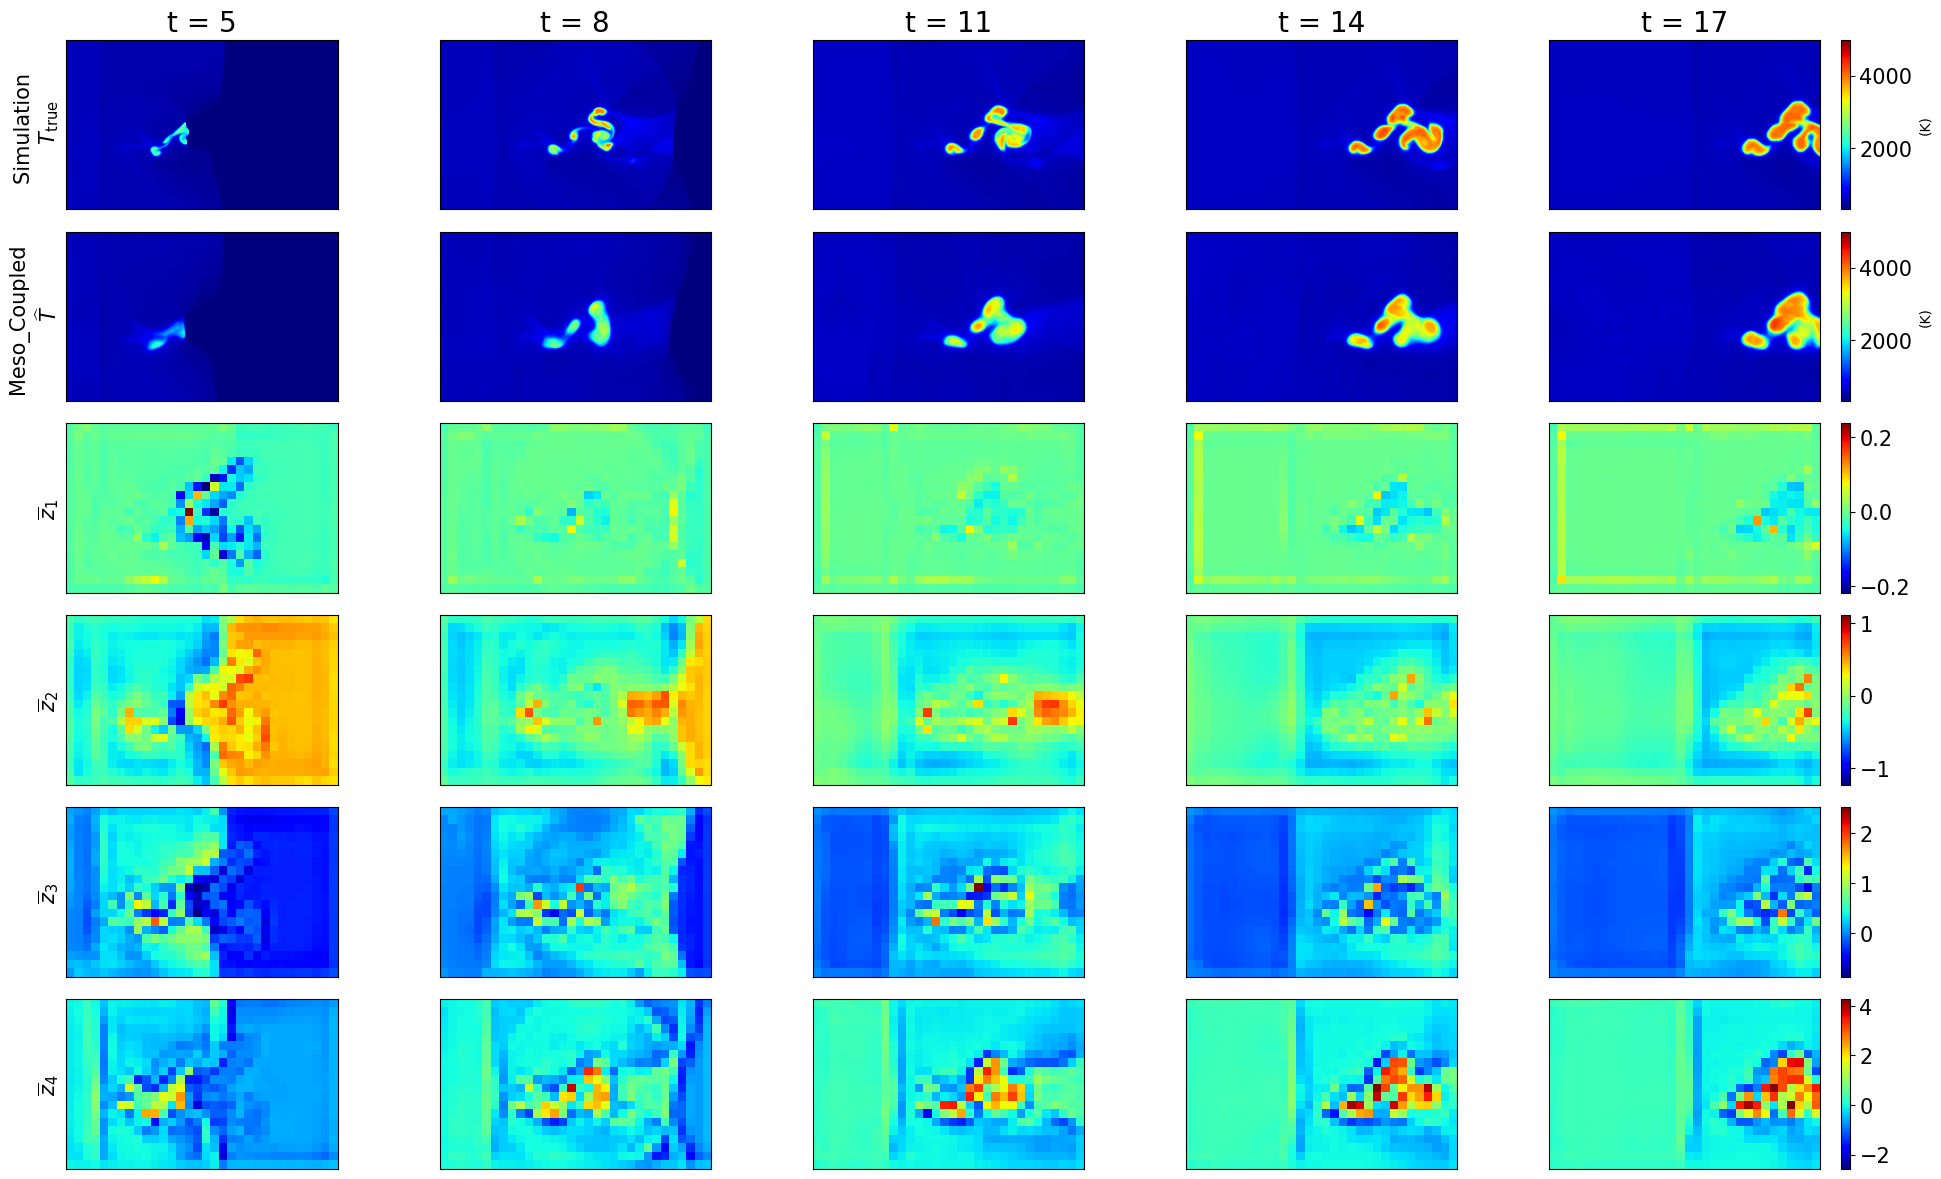

In [9]:
fig = plot_pred_field(x, z, t0=5, ts=3, field_idx=field_idx, spatial_scale='micro', mean_var='mean')

### MicroDynamicsCoupledEfficient Prediction

In [10]:
ts_idx = 7
n_epochs = 40
fields = ['temperature', 'pressure', 'microstructure']
field_indices = [0, 1] # the chosen output_fields
output_fields=[(field_idx, fields[field_idx]) for field_idx in field_indices]
dynamics_model = 'unet'
dir = f"{dyn_dir(dynamics_model)['micro_dyn']['coupled']}"
weight_dir = os.path.join(dir, f'weights_{ts_idx+1}_ts_train_238')


micro_dynamics_coupled_efficient = MicroDynamicsCoupledEfficient(ts=ts_idx + 1,
                                                                fields = fields,
                                                                output_fields=output_fields,
                                                                latent_shape=(20, 32, 4),
                                                                loss_weights=[1, 1, 1e+1],
                                                                dynamics_model=dynamics_model)
                                                
### call on a sample
init_z_mean = latent_mean_traj[0:1, :,:,:, 0:1]
init_z_var = latent_var_traj[0:1, :,:,:, 0:1]
input = [init_z_mean, init_z_var, 1, output_fields]
micro_dynamics_coupled_efficient.call(input)
# load pretrain weights of the decoupled evolutions
micro_dynamics_coupled_efficient.load_micro_decoupled_evol(pretrain_ts=[0, 0, 0], n_epochs=[0, 0, 0])
###
micro_dynamics_coupled_efficient.load_weight(ts=ts_idx+1, n_epochs=n_epochs, weight_dir=weight_dir)
micro_dynamics_coupled_efficient.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002,beta_1=0.5,beta_2=0.99))

In [11]:
sample = 232# test samples 225 - 237; validation samples 220, 222;
init_step = 0
evol_step = 19
init_z_mean = latent_mean_traj[sample:sample+1, :,:,:, init_step:init_step+1]
init_z_var = latent_var_traj[sample:sample+1, :,:,:, init_step:init_step+1]
input = [init_z_mean, init_z_var, evol_step, output_fields]
x_evol_traj, z_mean_traj, z_var_traj = micro_dynamics_coupled_efficient.call(input)
x_evol_traj, z_mean_traj, z_var_traj = x_evol_traj.numpy(), z_mean_traj.numpy(), z_var_traj.numpy()
print((x_evol_traj.shape, z_mean_traj.shape)) 

((1, 160, 256, 2, 20), (1, 20, 32, 12, 20))


In [12]:
field_idx = 0
field_gt = state_traj[sample:sample+1,:,:, field_idx:field_idx+1, init_step:init_step+evol_step+1]
c0, c1 = (field_idx * micro_dynamics_coupled_efficient.latent_shape[2]), (( field_idx + 1) * micro_dynamics_coupled_efficient.latent_shape[2]) 
x = np.moveaxis(np.concatenate([field_gt, x_evol_traj[..., field_idx:field_idx+1, :]], axis=0), (0,1,2,3,4), (0,2,3,4,1))
z = np.moveaxis(np.concatenate([z_mean_traj[..., c0:c1, :], z_var_traj[..., c0:c1, :]], axis=0), (0,1,2,3,4), (0,2,3,4,1))

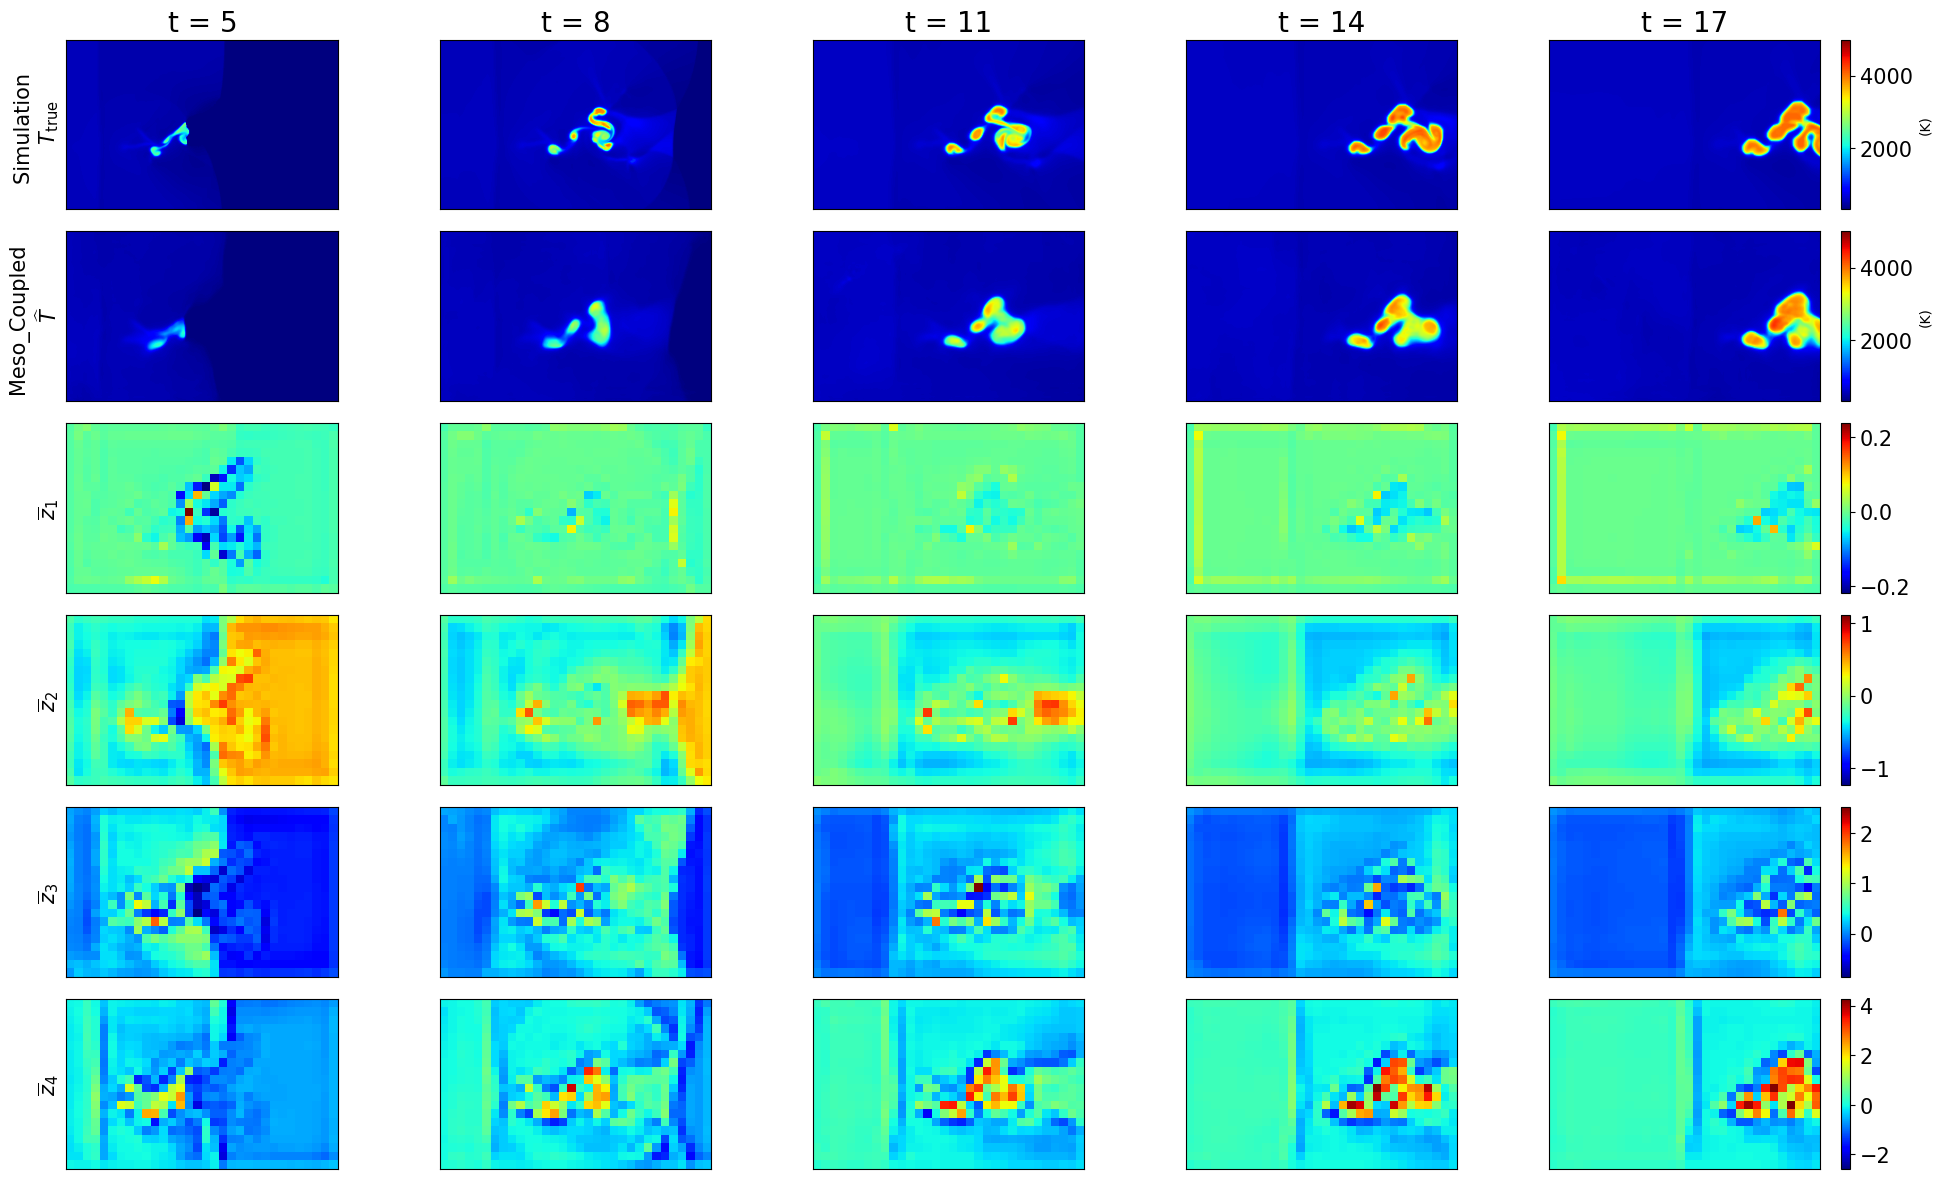

In [13]:
fig = plot_pred_field(x, z, t0=5, ts=3, field_idx=field_idx, spatial_scale='micro', mean_var='mean', n_rows=6)